# Statistics for Major League Baseball from 1871 through 2016 

The Lahman Baseball database created by Sean Lahman includes data from 2 current leagues(American and National), 4 other major leagues (American Association, Union Association, Players League and Federal League) and the National Association of 1871-1875.

When I started analyzing this extensive data, I was captivated by a lot of questions, puzzles and math.

I wanted to know the best teams. 

I wanted to know the interconnection between batting, pitching and fielding.

Has the popularity of baseball changed historically and how ?

Can I predict the performance of a player based on his earlier performance ?

To me, Home Runs are fascinating. How the bat hits the ball and hurls it far away ! I wanted to learn more about Home Runs.

In [1]:
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

__Correlation Between Shortstops and Designated Hitters__ :

While reading about baseball I came across the concept of designated hitter. I also read that Shortstop is one of the most demanding defensive positions. I would expect a Shortstop to be a poor batter. So I decided to put that to test, by studying the correlation between a Shortstop and a Designated Hitter.

The Appearances database provides the information I need :

In [3]:
Appearances_df = pd.read_csv('Appearances.csv')

The National and American Leagues operated under essentially identical rules until 1973, when the American League adopted the designated hitter (DH) rule, allowing its teams to use another hitter to bat in place of the (usually) weak-hitting pitcher. The National League did not adopt the DH rule.

I sliced the Appearances Dataframe accordingly :

In [4]:
designated_hitter_in_df = (Appearances_df[['yearID','lgID','G_ss','G_dh']].
                           query('yearID >= 1973 and lgID == "AL"'))

Then I computed pairwise correlation of its columns :

In [5]:
designated_hitter_in_df.corr()

,yearID,G_ss,G_dh
yearID,1.000000,-0.021655,-0.035351
G_ss,-0.021655,1.000000,-0.041045
G_dh,-0.035351,-0.041045,1.000000


Using Seaborn I plotted a Jointplot. To my convenience, it calls the function Pearson's r and also annotates the plot.

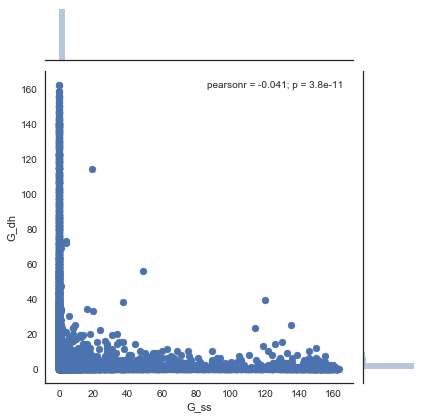

In [72]:
with sns.axes_style("white"):
    sns.jointplot(x=designated_hitter_in_df['G_ss'], y=designated_hitter_in_df['G_dh'])      

This shows the Correlation between Games played as Shortstop and Games played as Designated Hitter.

If I use log scale along y-axis :

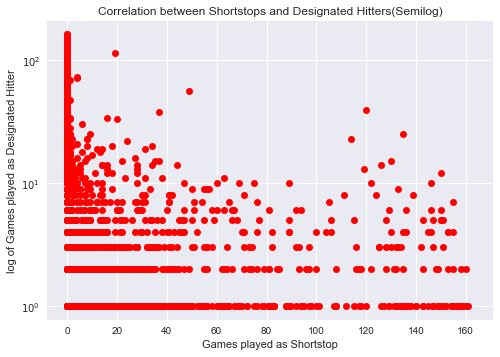

In [73]:
plt.semilogy(designated_hitter_in_df['G_ss'],designated_hitter_in_df['G_dh'],'ro')
plt.title('Correlation between Shortstops and Designated Hitters(Semilog)')
plt.xlabel('Games played as Shortstop')
plt.ylabel('log of Games played as Designated Hitter')

###### My analysis agreed with my expectation, in that, the Pearson's r came out to be negative. 
So in general, a good Shortstop is not a good Designated Hitter, and vice versa.

However since the r value is only -0.04, this particular relation is not so significant ! 

There are exceptional players like Alex Rodriguez who are good as both Shortstop and Designated Hitter !

###### Next, I want to know the players who are currently playing for MLB : 

In [8]:
Master_df = pd.read_csv('Master.csv')
#Master_df.hist()

I need only a few of the columns :

In [9]:
players_df = Master_df[['playerID','nameFirst','nameLast','birthYear','debut','finalGame']]
#players_df.hist()

Some of the date columns in my dataframes are string objects. Since I want to extract only 'Year' from them, I wrote a function which converts them to datetime format and then extracts 'Year' value.

In [10]:
def df_column_get_yr(df_column):
    
    def get_yr(date):
        return date.year
    return (pd.to_datetime(df_column)).apply(get_yr)

Applying this function to the 'finalGame' column :

In [11]:
final_Game_yr = df_column_get_yr(players_df['finalGame'])
#final_Game_yr.hist()

Now, to get the current players, I check if their final game is in year 2016.

In [12]:
current_players_df = players_df[final_Game_yr==2016]
#current_players_df

That is a slice. Since I won't be able to do certain operations on a slice, let me get a proper dataframe by merging the slice with the original.

In [13]:
Players_current_df = (players_df.merge(current_players_df,on=['playerID','nameFirst','nameLast',
                                                              'birthYear','debut',
                                                              'finalGame'],how='inner'))

Batting, Pitching and Fielding databases :

In [14]:
Batting_df = pd.read_csv('Batting.csv')
Pitching_df = pd.read_csv('Pitching.csv')
Fielding_df = pd.read_csv('Fielding.csv')

I realized that I have to merge dataframes many times in this analysis. So I wrote a function to do just that :

In [15]:
def df_merge(df1,df2,a_k):
    return df1.merge(df2, on=a_k, how='inner')

To know the current Batters, Pitchers and Fielders :

In [16]:
Batting_current_df = df_merge(Batting_df,Players_current_df,'playerID')

In [17]:
Pitching_current_df = df_merge(Pitching_df,Players_current_df,'playerID')

In [18]:
Fielding_current_df = df_merge(Fielding_df,Players_current_df,'playerID')

I would need to find 'on base percentage', 'slugging percentage' and 'on base plus slugging' statistics for different slices of the Batting dataframe. So I wrote functions for each of them.

In [19]:
def on_base_percentage(df,a,b,c,d,e):
    return (df[[a,b,c]].sum(axis=1))/(df[[d,b,c,e]].sum(axis=1))
#where a is 'H',b is 'BB',c is 'HBP',d is 'AB',e is 'SF

In [20]:
def slugging_percentage(df,a,b,c,d,e):
    return (df[a]+df[b]+2*df[c]+3*df[d])/df[e]
#where a is 'H',b is '2B',c is '3B',d is 'HR',e is 'AB'

In [21]:
def on_base_plus_slugging(df,a,b):
    return df[a]+df[b]
#where a is 'OBP',b is 'SLG'

I will now create new columns in my Batting_current dataframe :

In [22]:
Batting_current_df['OBP'] = on_base_percentage(Batting_current_df,'H','BB','HBP','AB','SF')

In [23]:
Batting_current_df['SLG'] = slugging_percentage(Batting_current_df,'H','2B','3B','HR','AB')

In [24]:
Batting_current_df['OPS'] = on_base_plus_slugging(Batting_current_df,'OBP','SLG')
Batting_current_df['OPS'].describe()

count    5368.000000
mean        0.553349
std         0.341450
min         0.000000
25%         0.319117
50%         0.650037
75%         0.767554
max         5.000000
Name: OPS, dtype: float64

I was curious to see who had this max OPS of 5 :

In [25]:
Batting_current_df['OPS'].argmax()

1263

In [26]:
Batting_current_df.loc[1263]

playerID      hernafe02
yearID             2008
stint                 1
teamID              SEA
lgID                 AL
G                    31
AB                    1
R                     1
H                     1
2B                    0
3B                    0
HR                    1
RBI                   4
SB                    0
CS                    0
BB                    0
SO                    0
IBB                   0
HBP                   0
SH                    1
SF                    0
GIDP                  0
nameFirst         Felix
nameLast      Hernandez
birthYear          1986
debut        2005-08-04
finalGame    2016-10-02
OBP                   1
SLG                   4
OPS                   5
Name: 1263, dtype: object

Statistics like this one here shows interesting information about a player. In 2008,Felix Hernandez, in his only At Bat of the season hit his first major league Home Run,a Grand Slam ! He became the first American League Pitcher to hit a Grand Slam.

###### Test Hypothesis about OPS average during World War 2 : 

I was curious to know the effects of World War 2 on MLB.
Thanks to President Roosevelt's Greenlight letter, baseball continued to be played during the war, allowing Americans to enjoy a sense of normalcy. However MLB played more older players, since younger players like Joe DiMaggio, Ted Williams served their nation off the diamond !

This must have brought the performance levels down.
I decided to check this with the "on base plus slugging" statistic which gauges the batter's overall ability.

I sliced the Batting dataframe and got this dataframe for the World War 2 period 1941-1945.

In [27]:
Batting_WW2_df = Batting_df.query('yearID>=1941 and yearID<=1945')

Following are the batting statistics for the war period :

In [28]:
OBP_WW2 = on_base_percentage(Batting_WW2_df,'H','BB','HBP','AB','SF')
SLG_WW2 = slugging_percentage(Batting_WW2_df,'H','2B','3B','HR','AB')
OPS_WW2 = OBP_WW2 + SLG_WW2

OPS_WW2.describe()

count    2712.000000
mean        0.536229
std         0.288776
min         0.000000
25%         0.368627
50%         0.568978
75%         0.702767
max         3.000000
dtype: float64

Following are the batting statistics for the whole period that this data is available:

In [29]:
OBP_overall = on_base_percentage(Batting_df,'H','BB','HBP','AB','SF')
SLG_overall = slugging_percentage(Batting_df,'H','2B','3B','HR','AB')
OPS_overall = OBP_overall + SLG_overall

OPS_overall.describe()

count    87435.000000
mean         0.554155
std          0.308963
min          0.000000
25%          0.383875
50%          0.603030
75%          0.733830
max          5.000000
dtype: float64

I chose to conduct a one-tailed Hypothesis Test.

The z value is less than z_critical value. 
So I can Reject The Null Hypothesis.


So simply looking at the Batting Statistics, I can say that the performance level did go down during the war. 

This could be a true significance, or could be due to noise in the data.
Its a Tentative Conclusion.
Correlation does not necessarily imply causation.

##### Now I would like to do some analysis for the purpose of future selection :


First, I want to find 'average peak performance years' for 'all the players' in the data, so that I can find how many 'more years of peak performance' my 'current players' have : 

For this, I find 'final game year' and 'debut year' from the slice, players dataframe, of the Master dataframe.

In [30]:
final_Game_yr = df_column_get_yr(players_df['finalGame'])

In [31]:
debut_yr = df_column_get_yr(players_df['debut'])

Then I find the difference between them to get the 'peak performance years'.

In [32]:
peak_yrs = final_Game_yr - debut_yr
#peak_yrs.nlargest(n=15)
#peak_yrs.hist()

The mean peak performance for all the players is :

In [33]:
peak_yrs.mean()

4.716393442622951

Now, for the current players :

In [34]:
final_Game_current_yr = df_column_get_yr(Players_current_df['finalGame'])

In [35]:
debut_current_yr = df_column_get_yr(Players_current_df['debut'])

In [36]:
peak_current_yrs = final_Game_current_yr - debut_current_yr

By subtracting 'peak performance years for current players' from the 'mean peak performance years for all players', I get the 'minimum more number of peak performance years' I can expect for my current players :

In [37]:
min_more_peak_yrs = 4.7 - peak_current_yrs
#min_more_peak_yrs.hist()

I create this column in the dataframe of my current players :

In [38]:
Players_current_df['Min_More_Peak_yrs'] = min_more_peak_yrs

I would like to consider their salaries too :

In [39]:
Salaries_df = pd.read_csv('salaries.csv')

I merge these 2 dataframes using the df_merge function I wrote earlier :

In [40]:
Salaries_current_df = df_merge(Salaries_df,Players_current_df,'playerID')

I am interested in the current salaries of these players. So I query :

In [41]:
current_salaries_df = (Salaries_current_df[['yearID','playerID','salary','Min_More_Peak_yrs']].
                       query('yearID==2016'))
#current_salaries_df.info()

So now I have information about my current players regarding how many more years they can perform well and what salaries they would expect.

Let me merge this information with the Batting information I have about my current players :

Since the 2 dataframes are of different sizes, and I do not want to lose any information from these 2 dataframes, I merge them this way :

In [42]:
Batting_Salaries_current_df = (Batting_current_df.merge(current_salaries_df, on='playerID',
                                                        how='left'))

Then I slice it :

In [43]:
choose_batters_df = (Batting_Salaries_current_df[['playerID','yearID_x','nameFirst','nameLast',
                                                  'teamID','lgID','OPS',
                                                  'salary','Min_More_Peak_yrs']].
                     query('yearID_x==2016'))
#choose_batters_df

Some players have more than 1 batting statistics for the current year. I take their mean:

In [44]:
Batter_choice_df = choose_batters_df.groupby(['playerID','nameFirst','nameLast']).mean()
Batter_choice_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1353 entries, (abadfe01, Fernando, Abad) to (zychto01, Tony, Zych)
Data columns (total 4 columns):
yearID_x             1353 non-null int64
OPS                  960 non-null float64
salary               805 non-null float64
Min_More_Peak_yrs    805 non-null float64
dtypes: float64(3), int64(1)
memory usage: 73.8+ KB


I see that some of the columns do not have information about certain players. But I want to retain those players, regardless. I might find the missing information from other sources.

In [45]:
Batter_choice_df['Min_More_Peak_yrs'].describe()

count    805.000000
mean      -0.764596
std        3.804658
min      -17.300000
25%       -3.300000
50%       -0.300000
75%        2.700000
max        4.700000
Name: Min_More_Peak_yrs, dtype: float64

I notice that some players are long past their peak performance years, but they could be valuable for their experience ! 

Others are just starting ! 

This information will help in making a wise choice.

Let me sort them by descending 'OPS', since I want to see my best batters at the top.

In [46]:
Current_Batter_choice_df = Batter_choice_df.sort_values('OPS',ascending=False)
#Current_Batter_choice_df.hist()

This Table will make it easy for me to choose a Batter for the next season !

Now for Pitcher :

I want to find the 'walks plus hits per inning pitched' for my current Pitchers :

In [47]:
Pitching_current_df['WHIP'] = ((Pitching_current_df['BB']+Pitching_current_df['H'])/
                               (Pitching_current_df['IPouts']/3))

Combining the dataframes for current Pitchers with their Salaries, I get :

In [48]:
Pitching_Salaries_current_df = (Pitching_current_df.merge(current_salaries_df, on='playerID',
                                                          how='left'))

Only looking at their current Pitching Statistics I get :

In [49]:
choose_pitchers_df = (Pitching_Salaries_current_df[['playerID','yearID_x','nameFirst',
                                                    'nameLast','teamID','lgID',
                                                    'WHIP','salary','Min_More_Peak_yrs']].
                      query('yearID_x==2016'))
#choose_pitchers_df

Some Pitchers have more than 1 pitching statistics. So I find their mean :

In [50]:
Pitcher_choice_df = choose_pitchers_df.groupby(['playerID','nameFirst','nameLast']).mean()

Let me arrange them in ascending order of 'WHIP'. That way I have my best Pitchers on top.

In [51]:
Current_Pitcher_choice_df = Pitcher_choice_df.sort_values('WHIP')
#Current_Pitcher_choice_df.info()
#Current_Pitcher_choice_df.hist()

As before, I see that I don't have salary and Min_More_Peak_yrs information for certain players. But I might find it later. 

I can recommend a Pitcher using this Table !

Now I want to have a Table of Fielders ready for next season :

I would like to know the 'fielding percentage' of my Fielders :

In [52]:
Fielding_current_df['FP'] = ((Fielding_current_df['PO']+Fielding_current_df['A'])/
                             (Fielding_current_df['PO']+Fielding_current_df['A']+
                              Fielding_current_df['E']))

Then combine this dataframe with the Salaries dataframe :

In [53]:
Fielding_Salaries_current_df = (Fielding_current_df.merge(current_salaries_df,on='playerID',
                                                         how='left'))

I am interested in their current Fielding Statistics :

In [54]:
choose_fielders_df = (Fielding_Salaries_current_df[['playerID','yearID_x','nameFirst',
                                                    'nameLast','teamID','lgID','FP',
                                                    'salary','Min_More_Peak_yrs']].
                     query('yearID_x==2016'))
#choose_fielders_df

Some Fielders have more than 1 fielding statistics for the current year. So I find their mean :

In [55]:
Fielder_choice_df = choose_fielders_df.groupby(['playerID','nameFirst','nameLast']).mean()

Arranging them in the descending order of their fielding percentages :

In [56]:
Current_Fielder_choice_df = Fielder_choice_df.sort_values('FP',ascending=False)
#Current_Fielder_choice_df.hist()
#Current_Fielder_choice_df.info()

Again I see that some columns have information missing, which I will have to acquire later.

I can recommend a Fielder using this Table !

These Tables give me a good idea about choosing players. But I have to caution about their accuracy, because I have not taken all kinds of Statistics into consideration. Also I have not performed any targeted tests. Statistical tests are important for making accurate conclusions.

###### Let's see which teams have been the Toppers in last 10 years of MLB :

In [57]:
Teams_df = pd.read_csv('Teams.csv')

I slice the dataframe and get the data for last 10 years :

In [58]:
Teams_10_yrs_df = Teams_df.query('yearID>2006 and yearID<=2016')
#Teams_10_yrs_df.info()

I further slice it to get data for Top 5 ranking teams :

In [59]:
Teams_10_yrs_ranked5_df = Teams_10_yrs_df.query('Rank>=1 and Rank<=5')
#Teams_10_yrs_ranked5_df.loc[Teams_10_yrs_ranked5_df['teamID']=="OAK"]

Then I get a list of teams that ranked Top 5 in last 10 years :

In [60]:
top5_teams = Teams_10_yrs_ranked5_df['teamID'].unique()
top5_teams

array(['ARI', 'ATL', 'BAL', 'BOS', 'CHA', 'CHN', 'CIN', 'CLE', 'COL',
       'DET', 'FLO', 'HOU', 'KCA', 'LAA', 'LAN', 'MIL', 'MIN', 'NYA',
       'NYN', 'OAK', 'PHI', 'SDN', 'SEA', 'SFN', 'SLN', 'TBA', 'TEX',
       'TOR', 'WAS', 'PIT', 'MIA'], dtype=object)

With the help of the list, I extract information about the teams. I see that some teams have had different names over the years. So I retain only their latest name and drop the old ones :

In [61]:
Top5_last10yrs_df =((Teams_10_yrs_ranked5_df[['teamID','name','park']].
                 loc[Teams_10_yrs_ranked5_df['teamID'].isin(top5_teams)]).
                drop_duplicates('name',keep='last'))

These teams have ranked Top 5 in last 10 years.

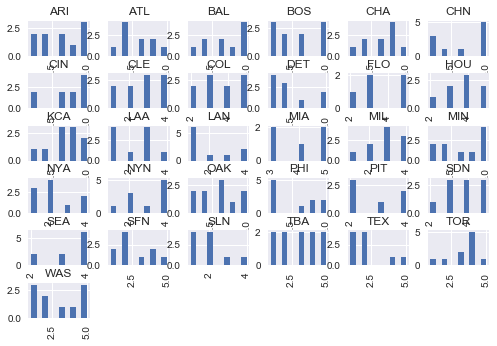

In [62]:
Teams_10_yrs_ranked5_df['Rank'].hist(by=Teams_10_yrs_ranked5_df['teamID'])
plt.title('Top5 TeamRankings Last10Years')
plt.xlabel('Ranks')
plt.ylabel('FrequencyIn10Years')

These histograms show at a glance all the Top 5 Teams from last 10 Years.

The horizontal axes show the Ranks.

The vertical axes show the Frequency of those Ranks in last 10 Years.

###### I want to see how the popularity of Baseball has been over the years.

For this, I found the mean home attendance each decade and then plotted them.

I needed a function that would convert an year to a decade it falls in :

In [63]:
def convert_to_decade(yr):
    decade = str(yr)[:3]
    return decade

Applying the function to the column 'yearID' in the Teams dataframe, I grouped the dataframe by decade, found mean of the home attendance for each decade, and then plotted the 'mean attendance' against the 'decades'.

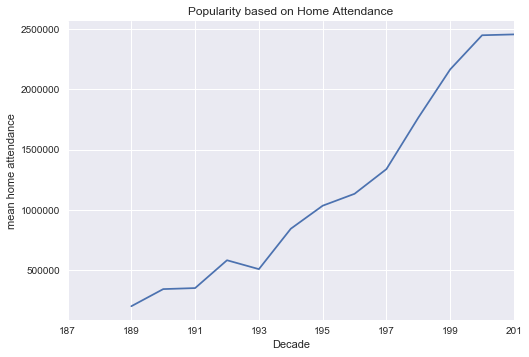

In [74]:
Teams_df['attendance'].groupby(Teams_df['yearID'].apply(convert_to_decade)).mean().plot()
plt.xlabel('Decade')
plt.ylabel('mean home attendance')
plt.title('Popularity based on Home Attendance')

This plot shows a continuous rise in Home Attendance. I wonder why there was a dip between 1920 and 1940 ! Could it be because of The Great Depression ?

I cannot make any sure statement about the attendance since there are some missing values in the column. Also I have used mean attendances to plot my graph. This also makes it an estimated graph.

#### A plot of Games and Wins Per Decade :

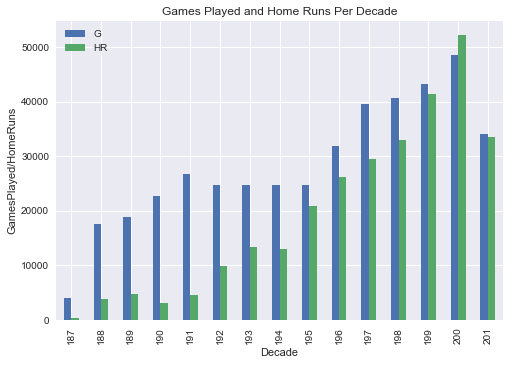

In [65]:
(Teams_df[['G','HR']].groupby(Teams_df['yearID'].apply(convert_to_decade)).
 sum().plot(kind='bar').set_ylabel('GamesPlayed/HomeRuns'))
plt.xlabel('Decade')
plt.title('Games Played and Home Runs Per Decade')

This is interesting ! 

Compared to number of games played, number of Home Runs made per decade rose significantly over the years !

Did the game become more competitive over the years ? Did baseball players improve their technique over the years ?

#### A pie plot of Games Per Decade :

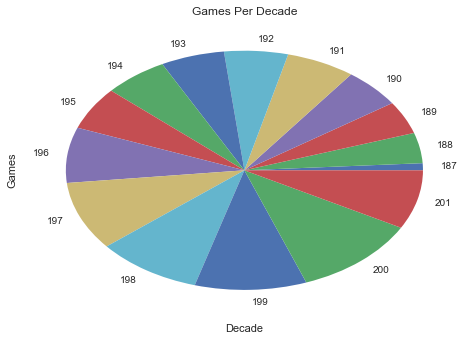

In [66]:
Teams_df['G'].groupby(Teams_df['yearID'].apply(convert_to_decade)).sum().plot(kind='pie')
plt.title('Games Per Decade')
plt.xlabel('Decade')
plt.ylabel('Games')

###### Winners Win :

I wanted to see what I can learn about Winners.

The SeriesPost database provides the number of games won and lost by the Winning Teams.

In [69]:
SeriesPost_df = pd.read_csv('SeriesPost.csv')

A bar plot of Wins & Losses by the Winning Teams per decade :

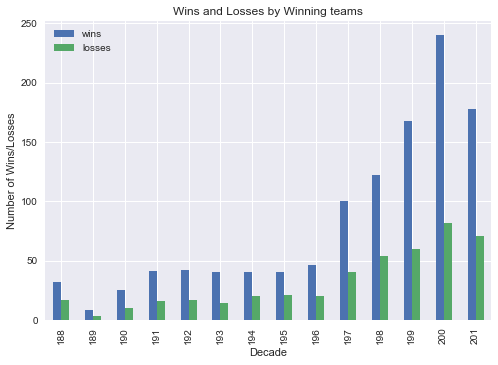

In [70]:
(SeriesPost_df[['wins','losses']].groupby(SeriesPost_df['yearID'].apply(convert_to_decade)).
 sum().plot(kind='bar'))
plt.title('Wins and Losses by Winning teams')
plt.xlabel('Decade')
plt.ylabel('Number of Wins/Losses')

I did expect the Winning Teams to have more wins than losses.

But I was surprised to see the wins to be this much prominent than the losses.

Winners Win because they are consistent about it. They work hard, Play hard !

###### Was I successful in answering my questions, solving my puzzles mentioned at the beginning of this analysis ? 

Yes, now I know the Top5 Ranking Teams from last 10 years.

By looking at the correlation between Shortstop and Designated Hitter, I satisfied my curiosity about the interconnection between Batter and Fielder. I can apply the same technique for other correlations.

I studied the Popularity of Baseball over the years based on home attendance. My study showed an almost continuous increase in the popularity.

I also found that more Home Runs are being hit today than before.

I learned that Winners win because they are really good at the game, and not just by chance.

My Hypothesis Test about Batting Statistics for the World War 2 period showed me that similar Hypothesis Tests can be done for any other period and any other Statistics.

I was able to gather information about Batting, Pitching and Fielding for players that are currently playing. With some calculations I deduced more information that will be helpful in choosing Players for the next season.

After having a good variety of Batters, Pitchers and Fielders in my team, I can further consider the Park Factor. The Teams Dataframe has scores of Batting Park Factor and Pitching Park Factor. I can merge the Teams Dataframe with Parks Dataframe retaining columns teamID, park, BPF and PPF from Teams Dataframe and all columns from Parks Dataframe.
Then, when my Team plays, I can line up my players depending on whether the particular park is good for Hitters or Pitchers !

Applying further Data Analytics to this Baseball Database, more research is possible.

The Game could be further refined and more talent can be tapped into.

On my way I saw so many interesting Statistics. 

Its one thing to like a Game. Its a whole new thing to study the game statistically.

It gives so many insights that you start to love the Game !

I could not have done this without the help of Google Searches, Pandas Documentation, Matplotlib and Seaborn Documentation, Stack Overflow users, Udacity Lectures and much more !